## Hospital Length of stay using LightGBM Model and  Tranformer Models

In [3]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
#from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [5]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [6]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients.DEATHDATE.fillna("2021-01-01", inplace = True) 
patients.DEATHDATE = pd.to_datetime(patients["DEATHDATE"])
patients.BIRTHDATE =  pd.to_datetime(patients["BIRTHDATE"])
patients["age"] =patients.DEATHDATE- patients.BIRTHDATE
patients['age'] = patients.age.astype('timedelta64[Y]').astype('int')
patients["healthcare_coverage_ratio"] = patients.HEALTHCARE_COVERAGE / patients.HEALTHCARE_EXPENSES
patients = patients[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
patients = patients.rename(columns = {"Id": "patient"})

In [7]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    data = data.rename(columns = {"Id": "patient"})
    return data

In [8]:
patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [9]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [10]:
# Careplan

careplan_df = pd.read_csv("100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [11]:

careplan_df = pd.merge(careplan_df, patients,  on='patient', how = "left")

careplan_df_test = pd.merge(careplan_df_test, patients_test,  on='patient', how = "left")

In [12]:
#Conditions

conditions_df = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [13]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [14]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [15]:
medications_df = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [16]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [17]:
#Observations

observations_df = pd.read_csv("100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [18]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [19]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [20]:
observations_df.head()

,patient,patient's_observation_of_Respiratory_rate,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Body_Weight,patient's_observation_of_Heart_rate,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,patient's_observation_of_Glomerular_filtration_rate173_sq_Mpredicted,...,patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Chloride_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Sodium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_MCHC_Massvolume_by_Automated_count,patient's_observation_of_Erythrocyte_distribution_width_Ratio_by_Automated_count,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
1070905,71c72728-f028-4eb8-8e4e-1afa016d22ca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Hemoglobin_A1cHemoglobintotal_in_Blood,1,1
11987201,2f1097a3-6753-4aeb-a1e0-aa1402e9cd0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Pain_severity__010_verbal_numeric_rating_Score...,1,1
1200957,4e422cdb-2663-407e-a2d0-e621736e60fb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Body_Mass_Index,1,1
4653066,fb99dee3-dd5d-4fc3-8bce-1c335157583f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Carbon_dioxide__total_Molesvolume_in_Serum_or_...,1,1
6642353,5006571d-c026-4abe-98cd-e55f79500ffe,0,78.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Diastolic_Blood_Pressure,1,1


In [21]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [22]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [23]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [24]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [25]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [26]:
encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [27]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [28]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [29]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [30]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [31]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [32]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [33]:
def merger(data1, data2, data3, data4,data5, data6, data7, data8, join_keys, goal):
    merged_df = pd.merge(data1, data2, on = join_keys)
    merged_df = pd.merge(merged_df, data3, on = join_keys)
    merged_df = pd.merge(merged_df, data4, on = join_keys)
    return merged_df
    

In [34]:
merged_train= pd.merge(careplan_df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")


In [35]:
merged_train.columns

Index(['patient', 'careplan_start', 'careplan_end', 'careplan_desc',
       'careplan_reason', 'Infectious disease care plan record artifact',
       'Diabetes self management plan',
       'Lifestyle education regarding hypertension',
       'Self-care interventions procedure', 'Respiratory therapy',
       ...
       'patient's_alergy_of_Allergy to grass pollen',
       'patient's_alergy_of_Allergy to tree pollen',
       'patient's_alergy_of_House dust mite allergy',
       'patient's_alergy_of_Shellfish allergy',
       'patient's_alergy_of_Allergy to bee venom',
       'patient's_alergy_of_Allergy to peanuts',
       'patient's_alergy_of_Allergy to fish',
       'patient's_alergy_of_Allergy to nut', 'patient's most seen allergy',
       'doctor_count_per_city'],
      dtype='object', length=172)

In [36]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7788 entries, 0 to 7787
Columns: 172 entries, patient to doctor_count_per_city
dtypes: float64(111), int64(7), object(54)
memory usage: 10.3+ MB


In [37]:
merged_test= pd.merge(careplan_df_test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")


In [38]:
#merged_test= pd.merge(careplan_df, conditions_df, on = ["patient"])
#merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)

In [40]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True)

In [41]:
## let's convert our date objects into datetime objects for further usage

data.careplan_end = pd.to_datetime(data.careplan_end)
data.careplan_start = pd.to_datetime(data.careplan_start)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 2482 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data = data.drop([ "careplan_desc", "careplan_reason"], 1)

In [45]:
data.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2020-03-13,2020-04-14 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2252343c-ebeb-46c9-8dc4-5ff972b7cf16,2020-03-06,2020-03-25 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
2,62087ad7-001b-457c-83b5-bb86d44ec671,2020-03-13,2020-04-06 00:00:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,d328bcab-962b-4727-be9a-cffcede35251,2020-02-12,2020-03-17 00:00:00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,e0c81187-8c7f-4bb4-9693-c0936941f838,2020-03-10,2020-04-07 00:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dander (animal) allergy,0.0


In [46]:
df = data.copy()
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2020-03-13,2020-04-14 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2252343c-ebeb-46c9-8dc4-5ff972b7cf16,2020-03-06,2020-03-25 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
2,62087ad7-001b-457c-83b5-bb86d44ec671,2020-03-13,2020-04-06 00:00:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,d328bcab-962b-4727-be9a-cffcede35251,2020-02-12,2020-03-17 00:00:00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,e0c81187-8c7f-4bb4-9693-c0936941f838,2020-03-10,2020-04-07 00:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dander (animal) allergy,0.0


### Let's create our target feature, careplan duration


In [47]:
df = df.sort_values("careplan_start")
df.careplan_end = pd.to_datetime(df.careplan_end, format='%Y-%m-%d', errors='coerce')
df.careplan_start = pd.to_datetime(df.careplan_start, format='%Y-%m-%d', errors='coerce')
df["careplan_duration"] = (df.careplan_end - df.careplan_start).dt.days
df = df.reset_index(drop = True)
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration
0,7397c518-0e28-4c87-b45b-da5269fd35f4,2020-01-29,2020-02-15,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,17.0
1,14372762-148c-45a1-bf88-41890182ed89,2020-02-02,2020-02-16,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,14.0
2,22ecf2f5-acf6-4276-b2a8-b96e6cb12b0d,2020-02-02,2020-03-09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,36.0
3,1b255fb3-cdd6-4f99-b174-0ab6cd9cb012,2020-02-03,2020-03-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,36.0
4,c89543dd-a97b-496f-b774-afbf7b8f227a,2020-02-03,2020-02-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,14.0


In [48]:
#Create time features

df["start_month"] = df.careplan_start.dt.month
df["start_day"] = df.careplan_start.dt.day_of_year
df["start_week"] = df.careplan_start.dt.day_of_week
df["start_year"] = df.careplan_start.dt.year

In [49]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [50]:
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration,start_month,start_day,start_week,start_year
0,7397c518-0e28-4c87-b45b-da5269fd35f4,2020-01-29,2020-02-15,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0.0,17.0,1,29,2,2020
1,14372762-148c-45a1-bf88-41890182ed89,2020-02-02,2020-02-16,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,14.0,2,33,6,2020
2,22ecf2f5-acf6-4276-b2a8-b96e6cb12b0d,2020-02-02,2020-03-09,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1.0,36.0,2,33,6,2020
3,1b255fb3-cdd6-4f99-b174-0ab6cd9cb012,2020-02-03,2020-03-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,36.0,2,34,0,2020
4,c89543dd-a97b-496f-b774-afbf7b8f227a,2020-02-03,2020-02-17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,14.0,2,34,0,2020


In [51]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [52]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [53]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### LightGBM

In [55]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")

In [56]:
train = df.loc[(df.dataset == "train") & (df.careplan_duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())]

In [57]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### Train & Validation 

In [58]:
from sklearn.model_selection import train_test_split
X = train.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)
y = train.careplan_duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)


In [59]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

2.8365091852847497

In [60]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1))
lgb_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_mae = mae(test.careplan_duration, real_preds)
lgb_r2 = r2_score(test.careplan_duration, real_preds)



In [61]:
lgb_rmse

3.184814392750405

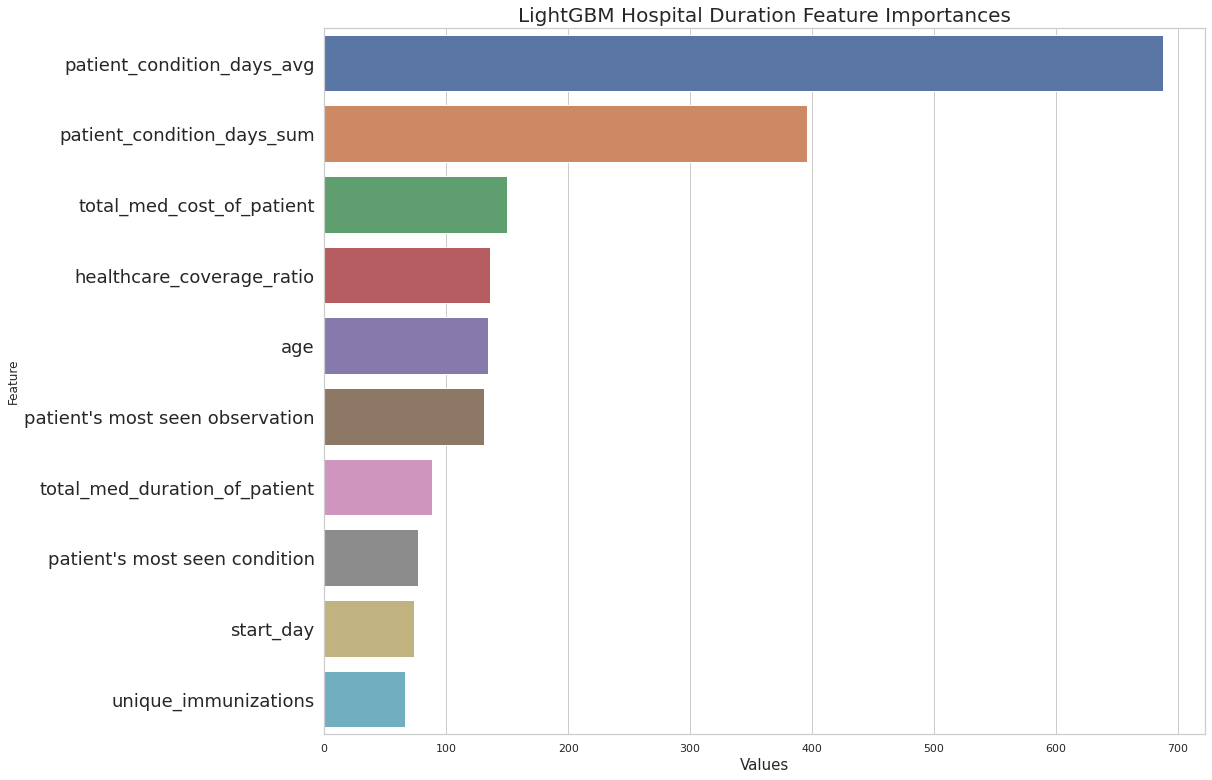

<Figure size 432x288 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(17, 11))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM Hospital Duration Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

In [63]:
top30_features = feature_imp.sort_values("Value", ascending = False)[:20].Feature.values.tolist()
reduced_categorical_features = []
reduced_numerical_features = []
for i in top30_features:
  if i in CATEGORICAL_FEATURES:
    reduced_categorical_features.append(i)
  else:
    reduced_numerical_features.append(i)

In [64]:
FEATURES = list(reduced_numerical_features) + list(reduced_categorical_features)

In [65]:
X = train.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)[FEATURES]
y = train.careplan_duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

2.919161619367981

In [66]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start",
                                      "careplan_end", "patient"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_mae = mae(test.careplan_duration, real_preds)
lgb_r2 = r2_score(test.careplan_duration, real_preds)


lgb_rmse

3.3702322593793306

### Parameter Optimization

In [67]:
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }

In [68]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
param_comb = 10

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc083eac890>,
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.99],
                                        'max_depth': [3, 4, 5, 6, 7, 10],
                                        'min_child_weight': [1, 5, 10, 15],
                                        'num_iterations': [100, 500, 1000],
                                        'num_leaves': [4, 8, 16, 32, 64, 80],
                                        'reg_lambda': [0.2, 0.5, 1, 1.5]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [69]:
print(random_search.best_params_)

{'reg_lambda': 0.2, 'num_leaves': 8, 'num_iterations': 500, 'min_child_weight': 1, 'max_depth': 4, 'colsample_bytree': 0.99}


In [70]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=reduced_categorical_features)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
print("Tuned LGBM Validation RMSE is ", val_result2)

Tuned LGBM Validation RMSE is  3.013530064676119


##Test

In [71]:
model.fit(X, y)

real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.careplan_duration, real_preds)
lgb_tuned_r2 = r2_score(test.careplan_duration, real_preds)
print("Tuned LGBM Test RMSE is ", lgb_tuned_rmse)

Tuned LGBM Test RMSE is  3.369144233246714


In [73]:
results = pd.DataFrame(test.careplan_duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.head()

,index,real,preds
0,0,36.0,28.963224
1,1,31.0,29.617527
2,2,27.0,28.093090
3,3,32.0,29.459751
4,4,25.0,23.317169


In [74]:
results = pd.DataFrame(test.careplan_duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.min()

index     0.00000
real     14.00000
preds    14.20082
dtype: float64

In [75]:
results = pd.DataFrame(test.careplan_duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
a.max()

index    212.000000
real      36.000000
preds     36.732396
dtype: float64

Text(0, 0.5, '% difference between real values and predictions')

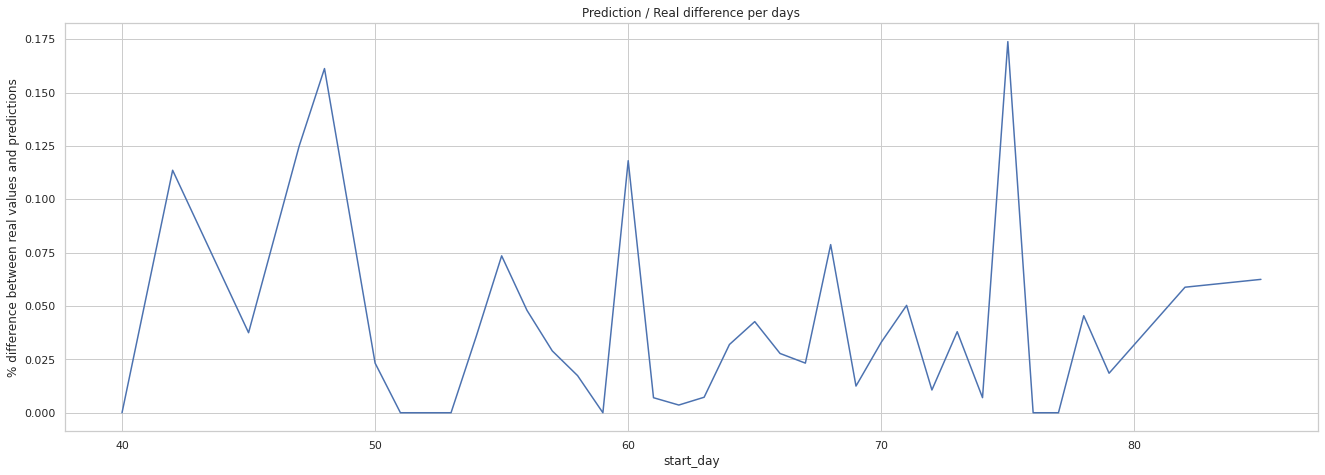

In [ ]:
test["preds"] = real_preds
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["careplan_duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

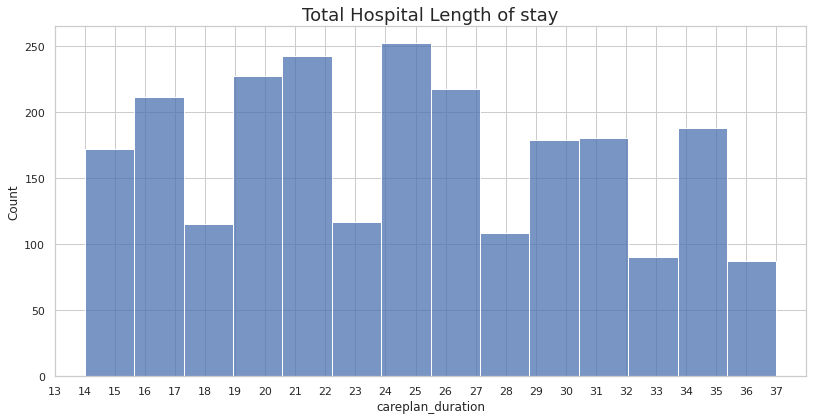

In [ ]:
plt.figure(figsize = (12,6))
sns.histplot(data = df, x = "careplan_duration")
plt.xticks(np.arange(10,38,1))
plt.xlim(13,38)
plt.title('Total Hospital Length of stay', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

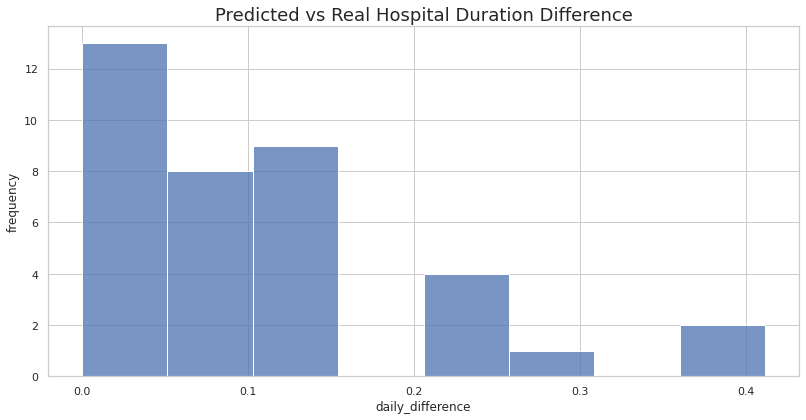

In [ ]:
plt.figure(figsize = (12,6))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real Hospital Duration Difference", fontsize = 18)
plt.ylabel("frequency")

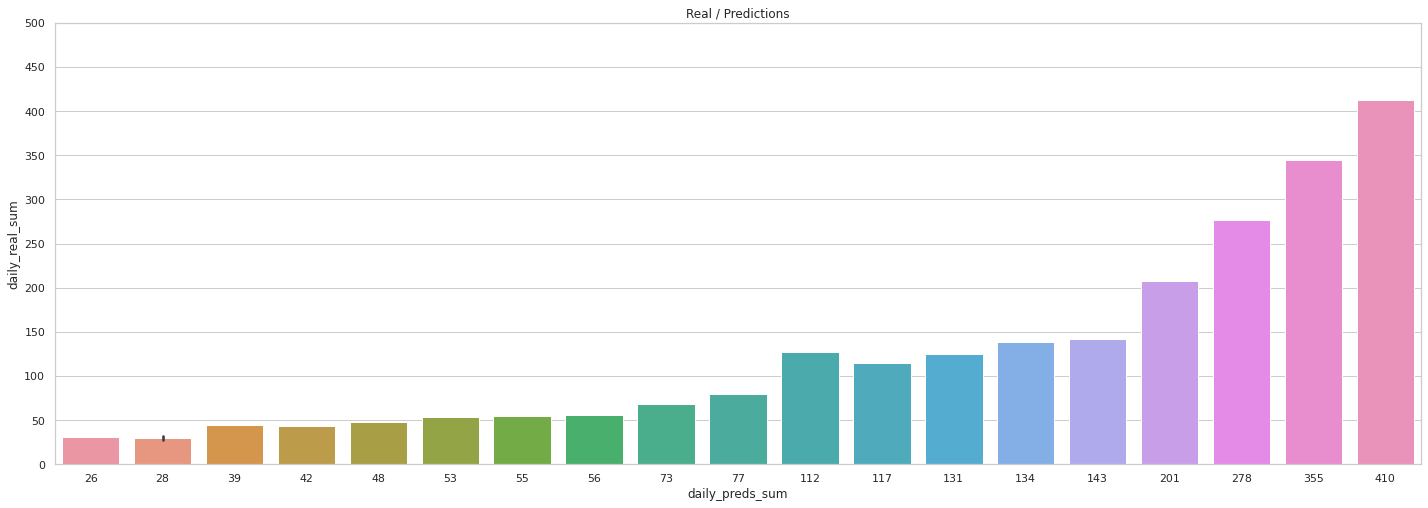

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

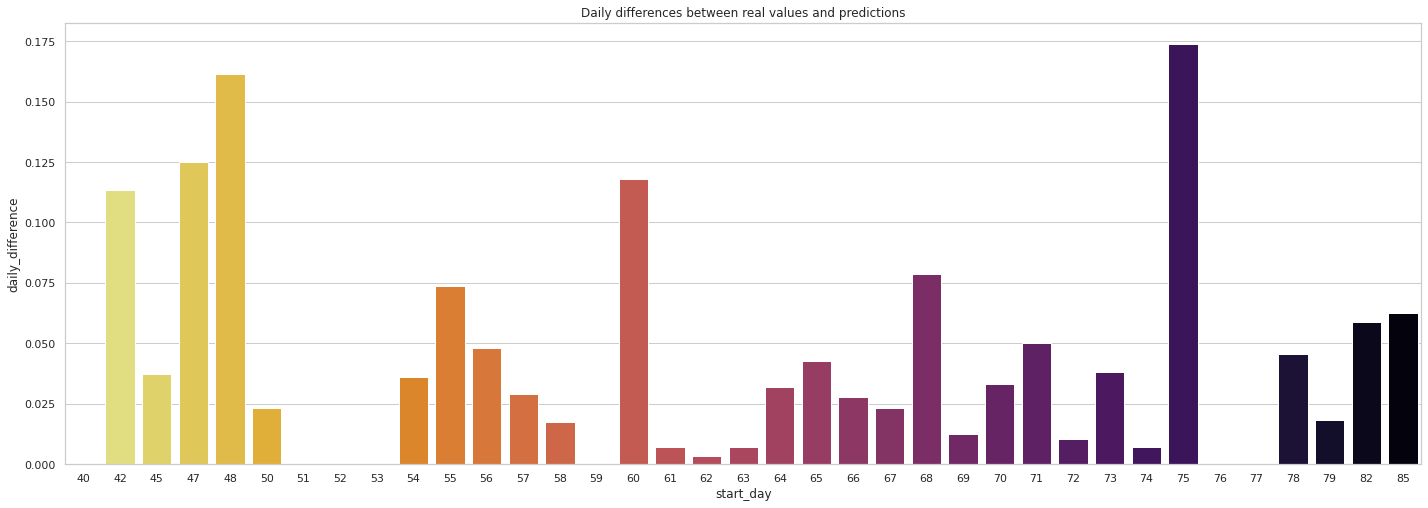

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

### FT - Transformer Models

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00


In [ ]:
!pip install tabtransformertf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [ ]:
data = df.copy()
data = data.rename(columns = {"careplan_duration" : "duration"})
data = data.loc[data.duration > 0].reset_index(drop = True)

In [ ]:
y = data['duration']
LABEL = "duration"

In [ ]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [ ]:
CATEGORICAL_FEATURES = reduced_categorical_features
NUMERIC_FEATURES = reduced_numerical_features

In [ ]:
NUMERIC_FEATURES


['patient_condition_days_avg',
 'patient_condition_days_sum',
 'healthcare_coverage_ratio',
 'age',
 'total_med_cost_of_patient',
 'start_day',
 'total_med_duration_of_patient',
 "patient's_condition_of_Viral sinusitis disorder",
 'total_unique_med_of_patient',
 'patient_condition_count',
 'start_week',
 "patient's Digital Radiographycount",
 'total_med_count_of_patient',
 "patient's_condition_of_Pneumonia disorder",
 'patient_condition_unique']

In [ ]:
CATEGORICAL_FEATURES

["patient's most seen observation",
 "patient's most seen condition",
 'CITY',
 'COUNTY',
 "patient's most used medication"]

In [ ]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [ ]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [ ]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [ ]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [ ]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 50

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/50
4/4 [==============================] - 13s 292ms/step - loss: 491.2503 - output_loss: 491.2503 - output_rmse: 22.1642 - val_loss: 397.8229 - val_output_loss: 397.8229 - val_output_rmse: 19.9455
Epoch 2/50
4/4 [==============================] - 0s 37ms/step - loss: 391.7374 - output_loss: 391.7374 - output_rmse: 19.7924 - val_loss: 359.9366 - val_output_loss: 359.9366 - val_output_rmse: 18.9720
Epoch 3/50
4/4 [==============================] - 0s 37ms/step - loss: 353.4456 - output_loss: 353.4456 - output_rmse: 18.8001 - val_loss: 338.5670 - val_output_loss: 338.5670 - val_output_rmse: 18.4002
Epoch 4/50
4/4 [==============================] - 0s 38ms/step - loss: 329.7836 - output_loss: 329.7836 - output_rmse: 18.1599 - val_loss: 320.8561 - val_output_loss: 320.8561 - val_output_rmse: 17.9125
Epoch 5/50
4/4 [==============================] - 0s 37ms/step - loss: 310.8788 - output_loss: 310.8788 - output_rmse: 17.6318 - val_loss: 305.5016 - val_output_loss: 305.5016 - val_outp

In [ ]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 50

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/50
4/4 [==============================] - 6s 244ms/step - loss: 595.1427 - output_loss: 595.1427 - output_rmse: 24.3955 - val_loss: 546.5408 - val_output_loss: 546.5408 - val_output_rmse: 23.3782
Epoch 2/50
4/4 [==============================] - 0s 30ms/step - loss: 537.0144 - output_loss: 537.0144 - output_rmse: 23.1736 - val_loss: 491.3540 - val_output_loss: 491.3540 - val_output_rmse: 22.1665
Epoch 3/50
4/4 [==============================] - 0s 32ms/step - loss: 485.5375 - output_loss: 485.5375 - output_rmse: 22.0349 - val_loss: 444.9354 - val_output_loss: 444.9354 - val_output_rmse: 21.0935
Epoch 4/50
4/4 [==============================] - 0s 31ms/step - loss: 442.8938 - output_loss: 442.8938 - output_rmse: 21.0450 - val_loss: 418.4382 - val_output_loss: 418.4382 - val_output_rmse: 20.4558
Epoch 5/50
4/4 [==============================] - 0s 30ms/step - loss: 415.9666 - output_loss: 415.9666 - output_rmse: 20.3953 - val_loss: 399.5071 - val_output_loss: 399.5071 - val_outpu

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 566ms/step


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.7 MB/s eta 0:00:00


### Parameter Optimization for Transformer Models

In [ ]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-30 16:03:30,867] A new study created in memory with name: no-name-1eced181-9440-4351-9342-a7f51fb2adfc


Epoch 1/50
4/4 [==============================] - 7s 298ms/step - loss: 506.8456 - output_loss: 506.8456 - output_rmse: 22.5132 - val_loss: 324.1696 - val_output_loss: 324.1696 - val_output_rmse: 18.0047
Epoch 2/50
4/4 [==============================] - 0s 37ms/step - loss: 295.8341 - output_loss: 295.8341 - output_rmse: 17.1998 - val_loss: 230.9251 - val_output_loss: 230.9251 - val_output_rmse: 15.1962
Epoch 3/50
4/4 [==============================] - 0s 39ms/step - loss: 222.0623 - output_loss: 222.0623 - output_rmse: 14.9018 - val_loss: 195.2942 - val_output_loss: 195.2942 - val_output_rmse: 13.9748
Epoch 4/50
4/4 [==============================] - 0s 43ms/step - loss: 189.2830 - output_loss: 189.2830 - output_rmse: 13.7580 - val_loss: 174.4749 - val_output_loss: 174.4749 - val_output_rmse: 13.2089
Epoch 5/50
4/4 [==============================] - 0s 39ms/step - loss: 167.4155 - output_loss: 167.4155 - output_rmse: 12.9389 - val_loss: 155.8965 - val_output_loss: 155.8965 - val_outpu

[I 2023-01-30 16:03:46,884] Trial 0 finished with value: 3.182884586570117 and parameters: {'numerical_bins': 124, 'embedding_dim': 58, 'depth': 4, 'heads': 2, 'attn_dropout': 0.13236281519527648, 'ff_dropout': 0.10786954350972527}. Best is trial 0 with value: 3.182884586570117.


Epoch 1/50
4/4 [==============================] - 6s 295ms/step - loss: 625.5040 - output_loss: 625.5040 - output_rmse: 25.0101 - val_loss: 515.2382 - val_output_loss: 515.2382 - val_output_rmse: 22.6989
Epoch 2/50
4/4 [==============================] - 0s 36ms/step - loss: 510.1452 - output_loss: 510.1452 - output_rmse: 22.5864 - val_loss: 402.4996 - val_output_loss: 402.4996 - val_output_rmse: 20.0624
Epoch 3/50
4/4 [==============================] - 0s 37ms/step - loss: 418.7346 - output_loss: 418.7346 - output_rmse: 20.4630 - val_loss: 354.3476 - val_output_loss: 354.3476 - val_output_rmse: 18.8241
Epoch 4/50
4/4 [==============================] - 0s 35ms/step - loss: 361.2194 - output_loss: 361.2194 - output_rmse: 19.0058 - val_loss: 327.7120 - val_output_loss: 327.7120 - val_output_rmse: 18.1028
Epoch 5/50
4/4 [==============================] - 0s 35ms/step - loss: 326.2884 - output_loss: 326.2884 - output_rmse: 18.0635 - val_loss: 304.3207 - val_output_loss: 304.3207 - val_outpu

[I 2023-01-30 16:04:01,743] Trial 1 finished with value: 6.215585172626515 and parameters: {'numerical_bins': 21, 'embedding_dim': 32, 'depth': 4, 'heads': 5, 'attn_dropout': 0.297442648200313, 'ff_dropout': 0.3970748641035908}. Best is trial 0 with value: 3.182884586570117.


Epoch 1/50
4/4 [==============================] - 8s 352ms/step - loss: 514.9775 - output_loss: 514.9775 - output_rmse: 22.6931 - val_loss: 313.9128 - val_output_loss: 313.9128 - val_output_rmse: 17.7176
Epoch 2/50
4/4 [==============================] - 0s 57ms/step - loss: 291.1914 - output_loss: 291.1914 - output_rmse: 17.0643 - val_loss: 249.5056 - val_output_loss: 249.5056 - val_output_rmse: 15.7957
Epoch 3/50
4/4 [==============================] - 0s 49ms/step - loss: 239.6846 - output_loss: 239.6846 - output_rmse: 15.4818 - val_loss: 227.6668 - val_output_loss: 227.6668 - val_output_rmse: 15.0886
Epoch 4/50
4/4 [==============================] - 0s 47ms/step - loss: 215.2326 - output_loss: 215.2326 - output_rmse: 14.6708 - val_loss: 204.5214 - val_output_loss: 204.5214 - val_output_rmse: 14.3011
Epoch 5/50
4/4 [==============================] - 0s 47ms/step - loss: 192.2256 - output_loss: 192.2256 - output_rmse: 13.8645 - val_loss: 183.8546 - val_output_loss: 183.8546 - val_outpu

1/1 [==============================] - 1s 820ms/step


[I 2023-01-30 16:04:20,217] Trial 2 finished with value: 4.259108634037979 and parameters: {'numerical_bins': 196, 'embedding_dim': 90, 'depth': 5, 'heads': 6, 'attn_dropout': 0.263398094952662, 'ff_dropout': 0.13539746405380776}. Best is trial 0 with value: 3.182884586570117.


Epoch 1/50
4/4 [==============================] - 8s 337ms/step - loss: 595.6611 - output_loss: 595.6611 - output_rmse: 24.4062 - val_loss: 502.8125 - val_output_loss: 502.8125 - val_output_rmse: 22.4235
Epoch 2/50
4/4 [==============================] - 0s 43ms/step - loss: 500.4013 - output_loss: 500.4013 - output_rmse: 22.3696 - val_loss: 455.5672 - val_output_loss: 455.5672 - val_output_rmse: 21.3440
Epoch 3/50
4/4 [==============================] - 0s 41ms/step - loss: 449.3781 - output_loss: 449.3781 - output_rmse: 21.1985 - val_loss: 421.5266 - val_output_loss: 421.5266 - val_output_rmse: 20.5311
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 415.1706 - output_loss: 415.1706 - output_rmse: 20.3757 - val_loss: 399.4744 - val_output_loss: 399.4744 - val_output_rmse: 19.9869
Epoch 5/50
4/4 [==============================] - 0s 40ms/step - loss: 388.0834 - output_loss: 388.0834 - output_rmse: 19.6998 - val_loss: 372.4199 - val_output_loss: 372.4199 - val_outpu

1/1 [==============================] - 1s 819ms/step


[I 2023-01-30 16:04:37,528] Trial 3 finished with value: 6.221354184594574 and parameters: {'numerical_bins': 128, 'embedding_dim': 30, 'depth': 5, 'heads': 5, 'attn_dropout': 0.2943771005926296, 'ff_dropout': 0.2811969043100419}. Best is trial 0 with value: 3.182884586570117.


Epoch 1/50
4/4 [==============================] - 9s 383ms/step - loss: 592.3696 - output_loss: 592.3696 - output_rmse: 24.3386 - val_loss: 485.3510 - val_output_loss: 485.3510 - val_output_rmse: 22.0307
Epoch 2/50
4/4 [==============================] - 0s 51ms/step - loss: 483.6458 - output_loss: 483.6458 - output_rmse: 21.9919 - val_loss: 422.7744 - val_output_loss: 422.7744 - val_output_rmse: 20.5615
Epoch 3/50
4/4 [==============================] - 0s 52ms/step - loss: 414.4427 - output_loss: 414.4427 - output_rmse: 20.3579 - val_loss: 374.8419 - val_output_loss: 374.8419 - val_output_rmse: 19.3608
Epoch 4/50
4/4 [==============================] - 0s 48ms/step - loss: 367.5977 - output_loss: 367.5977 - output_rmse: 19.1728 - val_loss: 348.3056 - val_output_loss: 348.3056 - val_output_rmse: 18.6629
Epoch 5/50
4/4 [==============================] - 0s 47ms/step - loss: 339.2908 - output_loss: 339.2908 - output_rmse: 18.4198 - val_loss: 328.7627 - val_output_loss: 328.7627 - val_outpu

[I 2023-01-30 16:04:57,240] Trial 4 finished with value: 6.223223570202923 and parameters: {'numerical_bins': 135, 'embedding_dim': 55, 'depth': 6, 'heads': 4, 'attn_dropout': 0.1933483606510687, 'ff_dropout': 0.48983418252280236}. Best is trial 0 with value: 3.182884586570117.


Number of finished trials: 5
Best trial: {'numerical_bins': 124, 'embedding_dim': 58, 'depth': 4, 'heads': 2, 'attn_dropout': 0.13236281519527648, 'ff_dropout': 0.10786954350972527}


In [ ]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=124,
    embedding_dim=58,
    depth=4,
    heads=2,
    attn_dropout= 0.1323,
    ff_dropout= 0.1078,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 150

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/150
4/4 [==============================] - 7s 296ms/step - loss: 557.6863 - output_loss: 557.6863 - output_rmse: 23.6154 - val_loss: 391.6450 - val_output_loss: 391.6450 - val_output_rmse: 19.7900
Epoch 2/150
4/4 [==============================] - 0s 35ms/step - loss: 358.4835 - output_loss: 358.4835 - output_rmse: 18.9337 - val_loss: 285.3283 - val_output_loss: 285.3283 - val_output_rmse: 16.8917
Epoch 3/150
4/4 [==============================] - 0s 35ms/step - loss: 276.3714 - output_loss: 276.3714 - output_rmse: 16.6244 - val_loss: 245.8005 - val_output_loss: 245.8005 - val_output_rmse: 15.6780
Epoch 4/150
4/4 [==============================] - 0s 39ms/step - loss: 238.4193 - output_loss: 238.4193 - output_rmse: 15.4408 - val_loss: 222.7404 - val_output_loss: 222.7404 - val_output_rmse: 14.9245
Epoch 5/150
4/4 [==============================] - 0s 34ms/step - loss: 214.7899 - output_loss: 214.7899 - output_rmse: 14.6557 - val_loss: 204.7927 - val_output_loss: 204.7927 - val_

In [ ]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 698ms/step


### Periodic Encoding FT Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

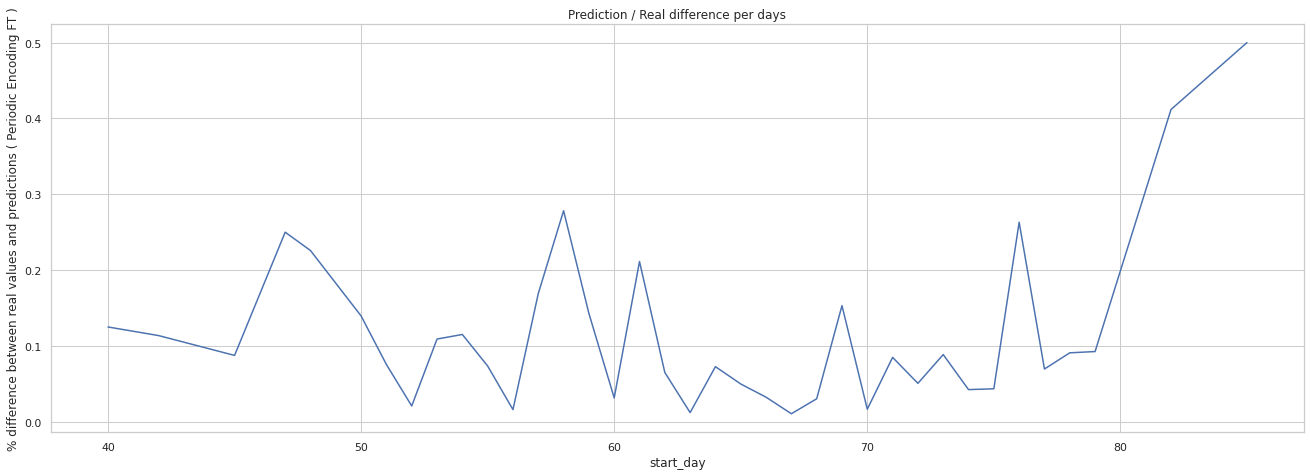

In [ ]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

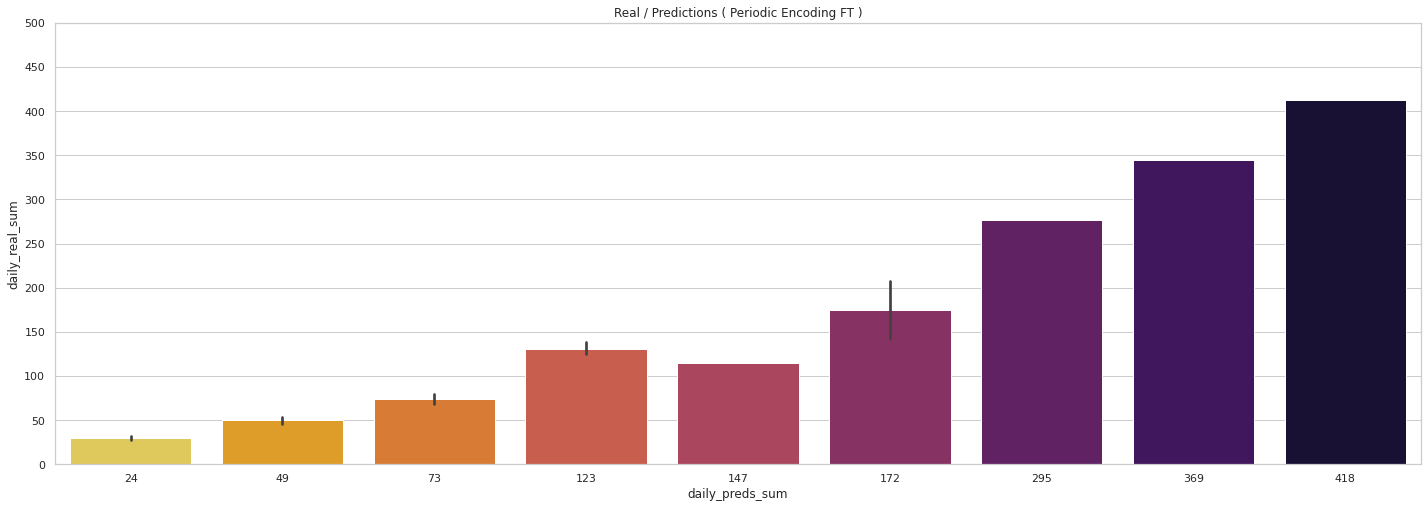

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

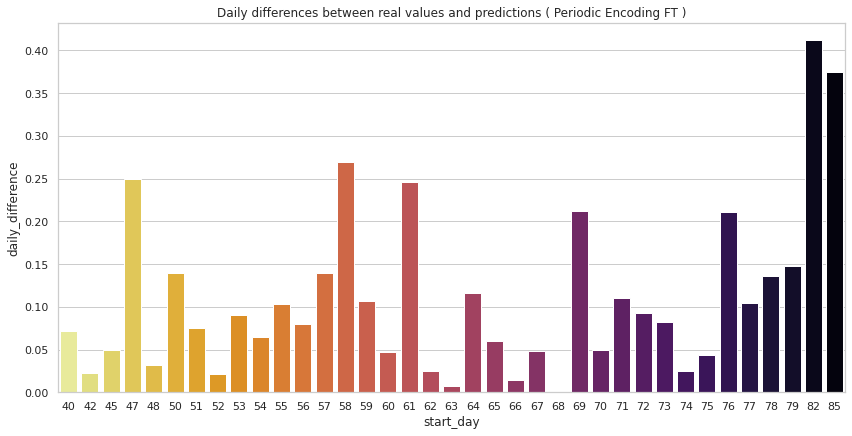

In [ ]:
plt.figure(figsize = (12,6))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [ ]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-30 16:05:48,012] A new study created in memory with name: no-name-1809e4de-619b-44f8-899b-8f11d227442d


Epoch 1/50
4/4 [==============================] - 4s 195ms/step - loss: 608.8745 - output_loss: 608.8745 - output_rmse: 24.6754 - val_loss: 498.7530 - val_output_loss: 498.7530 - val_output_rmse: 22.3328
Epoch 2/50
4/4 [==============================] - 0s 26ms/step - loss: 502.7183 - output_loss: 502.7183 - output_rmse: 22.4214 - val_loss: 429.1576 - val_output_loss: 429.1576 - val_output_rmse: 20.7161
Epoch 3/50
4/4 [==============================] - 0s 26ms/step - loss: 427.2824 - output_loss: 427.2824 - output_rmse: 20.6708 - val_loss: 388.0704 - val_output_loss: 388.0704 - val_output_rmse: 19.6995
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: 382.3320 - output_loss: 382.3320 - output_rmse: 19.5533 - val_loss: 365.8205 - val_output_loss: 365.8205 - val_output_rmse: 19.1264
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 354.9694 - output_loss: 354.9694 - output_rmse: 18.8406 - val_loss: 347.0213 - val_output_loss: 347.0213 - val_outpu

[I 2023-01-30 16:05:58,757] Trial 0 finished with value: 6.034943002868786 and parameters: {'numerical_bins': 87, 'embedding_dim': 43, 'depth': 2, 'heads': 8, 'attn_dropout': 0.27444541037145687, 'ff_dropout': 0.373132983189846}. Best is trial 0 with value: 6.034943002868786.


Epoch 1/50
4/4 [==============================] - 7s 294ms/step - loss: 607.6499 - output_loss: 607.6499 - output_rmse: 24.6506 - val_loss: 480.7050 - val_output_loss: 480.7050 - val_output_rmse: 21.9250
Epoch 2/50
4/4 [==============================] - 0s 34ms/step - loss: 487.3049 - output_loss: 487.3049 - output_rmse: 22.0750 - val_loss: 399.2848 - val_output_loss: 399.2848 - val_output_rmse: 19.9821
Epoch 3/50
4/4 [==============================] - 0s 36ms/step - loss: 405.4994 - output_loss: 405.4994 - output_rmse: 20.1370 - val_loss: 353.3315 - val_output_loss: 353.3315 - val_output_rmse: 18.7971
Epoch 4/50
4/4 [==============================] - 0s 35ms/step - loss: 353.0897 - output_loss: 353.0897 - output_rmse: 18.7907 - val_loss: 325.1084 - val_output_loss: 325.1084 - val_output_rmse: 18.0308
Epoch 5/50
4/4 [==============================] - 0s 35ms/step - loss: 321.2748 - output_loss: 321.2748 - output_rmse: 17.9241 - val_loss: 305.6165 - val_output_loss: 305.6165 - val_outpu

[I 2023-01-30 16:06:13,585] Trial 1 finished with value: 6.223158408862074 and parameters: {'numerical_bins': 95, 'embedding_dim': 50, 'depth': 4, 'heads': 2, 'attn_dropout': 0.3039572506172942, 'ff_dropout': 0.44485110460961635}. Best is trial 0 with value: 6.034943002868786.


Epoch 1/50
4/4 [==============================] - 9s 400ms/step - loss: 373.8264 - output_loss: 373.8264 - output_rmse: 19.3346 - val_loss: 122.6458 - val_output_loss: 122.6458 - val_output_rmse: 11.0746
Epoch 2/50
4/4 [==============================] - 0s 59ms/step - loss: 114.5079 - output_loss: 114.5079 - output_rmse: 10.7008 - val_loss: 96.4462 - val_output_loss: 96.4462 - val_output_rmse: 9.8207
Epoch 3/50
4/4 [==============================] - 0s 61ms/step - loss: 89.1708 - output_loss: 89.1708 - output_rmse: 9.4430 - val_loss: 78.0717 - val_output_loss: 78.0717 - val_output_rmse: 8.8358
Epoch 4/50
4/4 [==============================] - 0s 63ms/step - loss: 71.5995 - output_loss: 71.5995 - output_rmse: 8.4616 - val_loss: 63.0212 - val_output_loss: 63.0212 - val_output_rmse: 7.9386
Epoch 5/50
4/4 [==============================] - 0s 59ms/step - loss: 57.9813 - output_loss: 57.9813 - output_rmse: 7.6145 - val_loss: 52.2914 - val_output_loss: 52.2914 - val_output_rmse: 7.2313
Epoch

[I 2023-01-30 16:06:35,366] Trial 2 finished with value: 4.462221491786472 and parameters: {'numerical_bins': 151, 'embedding_dim': 98, 'depth': 6, 'heads': 8, 'attn_dropout': 0.07447184298005222, 'ff_dropout': 0.23928266561162398}. Best is trial 2 with value: 4.462221491786472.


Epoch 1/50
4/4 [==============================] - 5s 244ms/step - loss: 620.8206 - output_loss: 620.8206 - output_rmse: 24.9163 - val_loss: 557.6308 - val_output_loss: 557.6308 - val_output_rmse: 23.6142
Epoch 2/50
4/4 [==============================] - 0s 30ms/step - loss: 532.5461 - output_loss: 532.5461 - output_rmse: 23.0770 - val_loss: 503.0733 - val_output_loss: 503.0733 - val_output_rmse: 22.4293
Epoch 3/50
4/4 [==============================] - 0s 30ms/step - loss: 484.6125 - output_loss: 484.6125 - output_rmse: 22.0139 - val_loss: 468.4643 - val_output_loss: 468.4643 - val_output_rmse: 21.6440
Epoch 4/50
4/4 [==============================] - 0s 30ms/step - loss: 452.9686 - output_loss: 452.9686 - output_rmse: 21.2831 - val_loss: 442.5954 - val_output_loss: 442.5954 - val_output_rmse: 21.0380
Epoch 5/50
4/4 [==============================] - 0s 30ms/step - loss: 429.0431 - output_loss: 429.0431 - output_rmse: 20.7134 - val_loss: 424.1069 - val_output_loss: 424.1069 - val_outpu

[I 2023-01-30 16:06:48,247] Trial 3 finished with value: 6.194142386190545 and parameters: {'numerical_bins': 115, 'embedding_dim': 17, 'depth': 3, 'heads': 2, 'attn_dropout': 0.05286214038221948, 'ff_dropout': 0.05507688642661729}. Best is trial 2 with value: 4.462221491786472.


Epoch 1/50
4/4 [==============================] - 3s 147ms/step - loss: 550.9812 - output_loss: 550.9812 - output_rmse: 23.4730 - val_loss: 392.0792 - val_output_loss: 392.0792 - val_output_rmse: 19.8010
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 376.3470 - output_loss: 376.3470 - output_rmse: 19.3997 - val_loss: 327.3460 - val_output_loss: 327.3460 - val_output_rmse: 18.0927
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 320.5721 - output_loss: 320.5721 - output_rmse: 17.9045 - val_loss: 286.1899 - val_output_loss: 286.1899 - val_output_rmse: 16.9171
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 281.8697 - output_loss: 281.8697 - output_rmse: 16.7890 - val_loss: 255.3435 - val_output_loss: 255.3435 - val_output_rmse: 15.9795
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 251.9192 - output_loss: 251.9192 - output_rmse: 15.8720 - val_loss: 230.7542 - val_output_loss: 230.7542 - val_outpu

[I 2023-01-30 16:06:56,492] Trial 4 finished with value: 6.001418147468448 and parameters: {'numerical_bins': 145, 'embedding_dim': 79, 'depth': 1, 'heads': 4, 'attn_dropout': 0.4155205266429457, 'ff_dropout': 0.1019437395622671}. Best is trial 2 with value: 4.462221491786472.


Number of finished trials: 5
Best trial: {'numerical_bins': 151, 'embedding_dim': 98, 'depth': 6, 'heads': 8, 'attn_dropout': 0.07447184298005222, 'ff_dropout': 0.23928266561162398}


In [ ]:
study.best_trial.params

{'numerical_bins': 151,
 'embedding_dim': 98,
 'depth': 6,
 'heads': 8,
 'attn_dropout': 0.07447184298005222,
 'ff_dropout': 0.23928266561162398}

In [ ]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=151,
    embedding_dim=98,
    depth=6,
    heads=8,
    attn_dropout= 0.0744,
    ff_dropout= 0.2392,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 30

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/30
4/4 [==============================] - 9s 407ms/step - loss: 366.7509 - output_loss: 366.7509 - output_rmse: 19.1507 - val_loss: 105.0098 - val_output_loss: 105.0098 - val_output_rmse: 10.2474
Epoch 2/30
4/4 [==============================] - 0s 61ms/step - loss: 98.4252 - output_loss: 98.4252 - output_rmse: 9.9209 - val_loss: 77.9183 - val_output_loss: 77.9183 - val_output_rmse: 8.8271
Epoch 3/30
4/4 [==============================] - 0s 62ms/step - loss: 72.4334 - output_loss: 72.4334 - output_rmse: 8.5108 - val_loss: 62.4023 - val_output_loss: 62.4023 - val_output_rmse: 7.8995
Epoch 4/30
4/4 [==============================] - 0s 61ms/step - loss: 57.5835 - output_loss: 57.5835 - output_rmse: 7.5884 - val_loss: 51.0203 - val_output_loss: 51.0203 - val_output_rmse: 7.1429
Epoch 5/30
4/4 [==============================] - 0s 61ms/step - loss: 47.9561 - output_loss: 47.9561 - output_rmse: 6.9250 - val_loss: 44.1337 - val_output_loss: 44.1337 - val_output_rmse: 6.6433
Epoch 6/

In [ ]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 937ms/step


In [ ]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 21ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

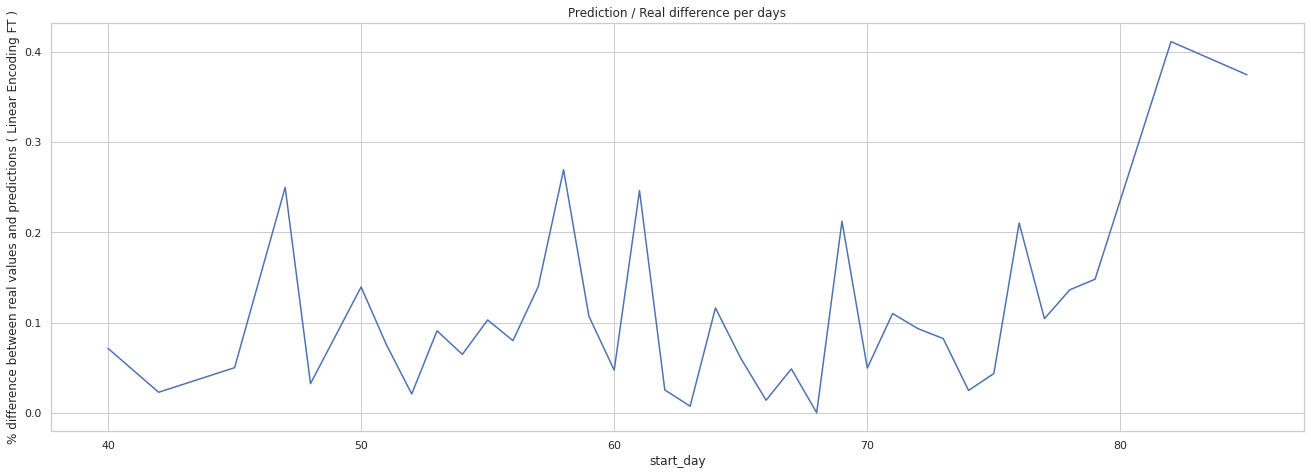

In [ ]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

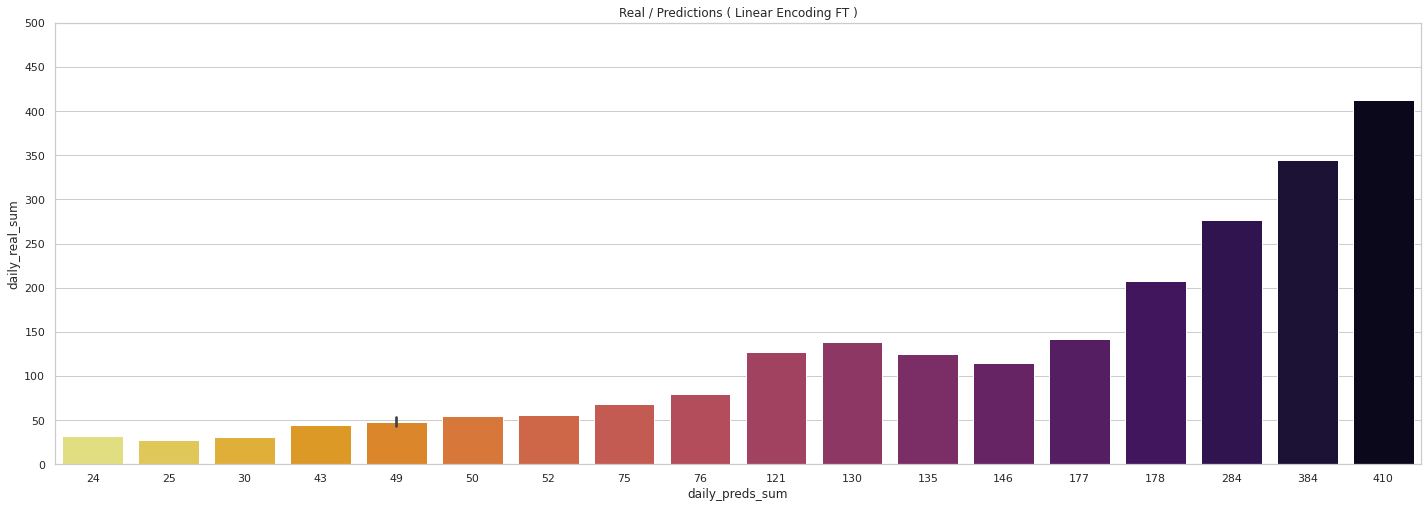

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

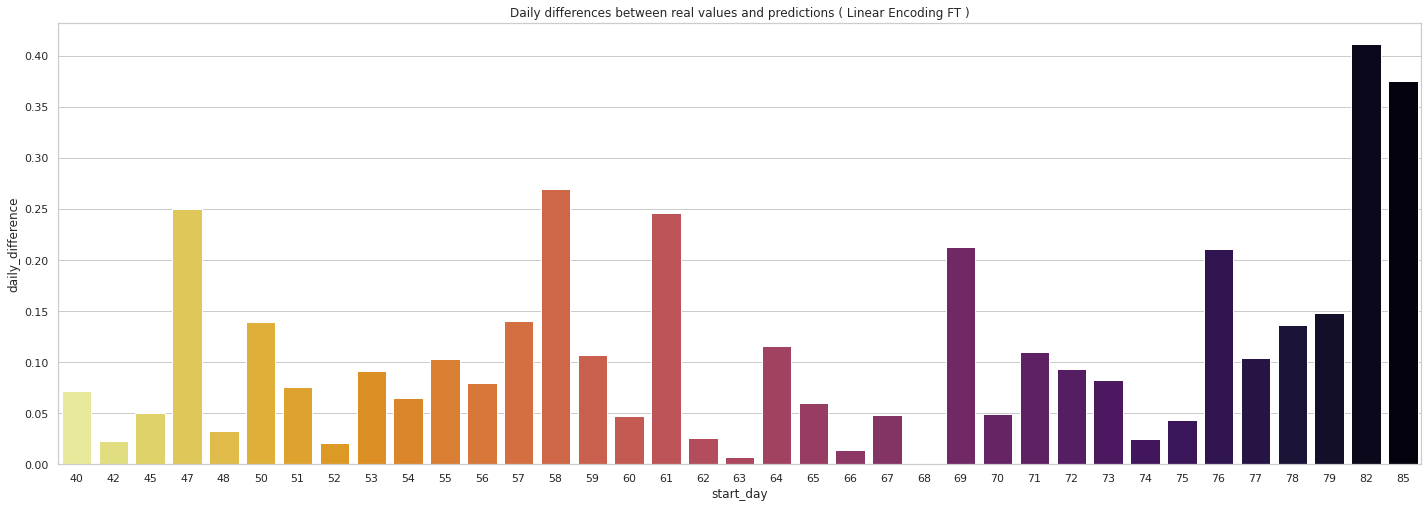

In [ ]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [ ]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,0.003441,5.315082,6.173188
Transformer - Periodic Encoding,0.003441,5.313738,6.184142
LightGBM,0.812316,1.540265,2.678994


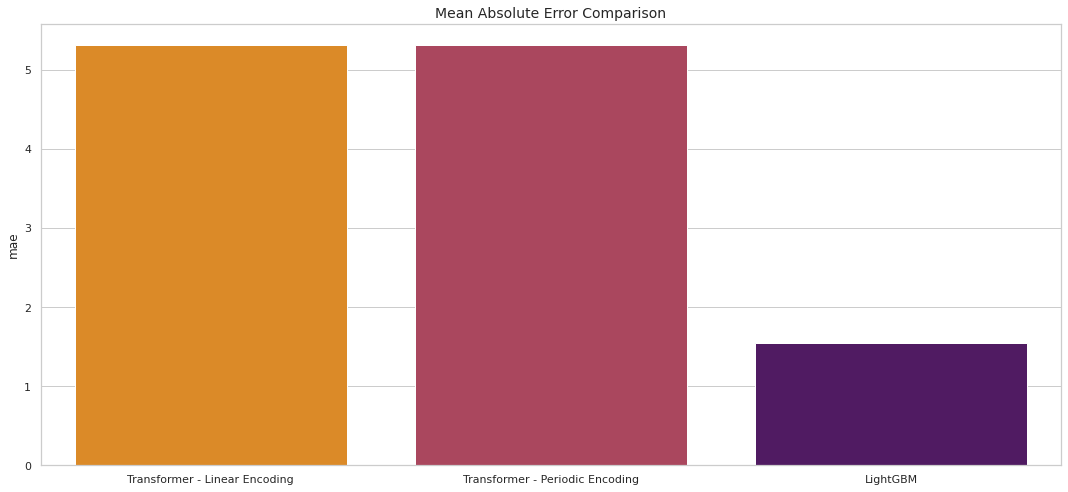

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


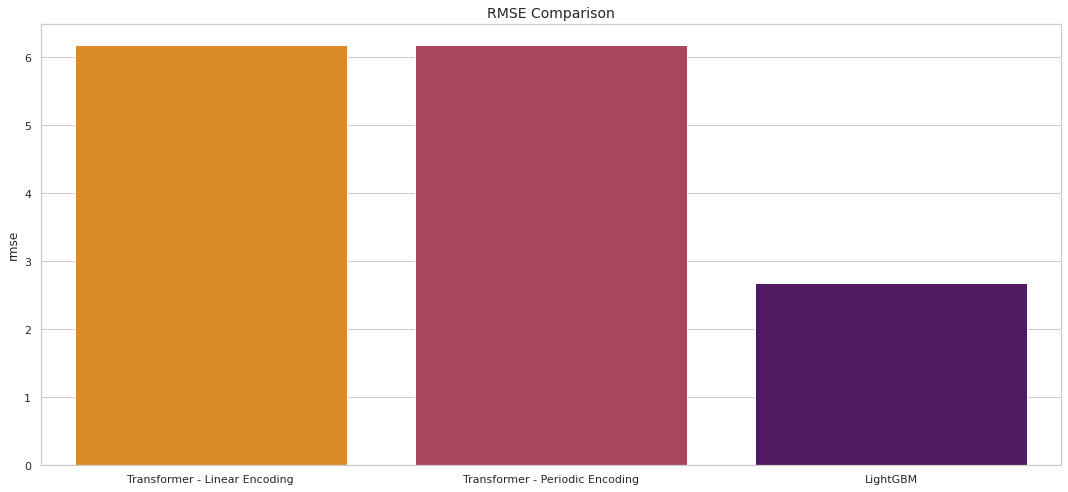

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


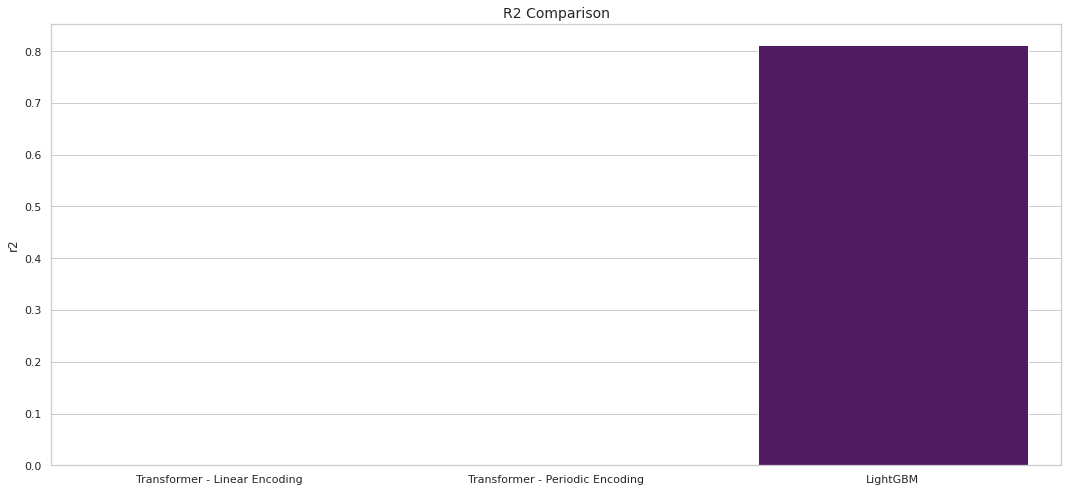

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [ ]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"])
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,0.164141,4.613865,5.653590
Transformer - Periodic Encoding TUNED,-0.010729,5.351964,6.216919
LightGBM TUNED,0.803461,1.559152,2.741465


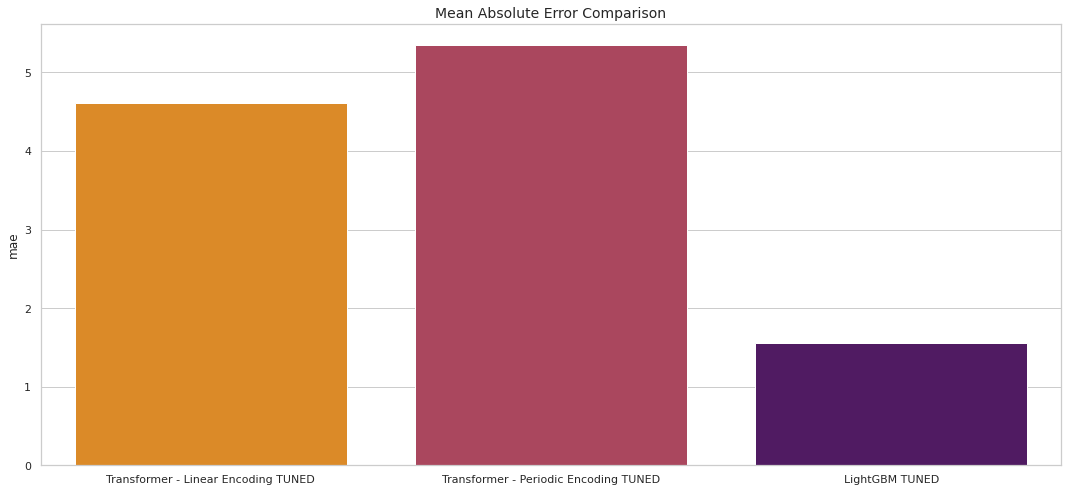

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


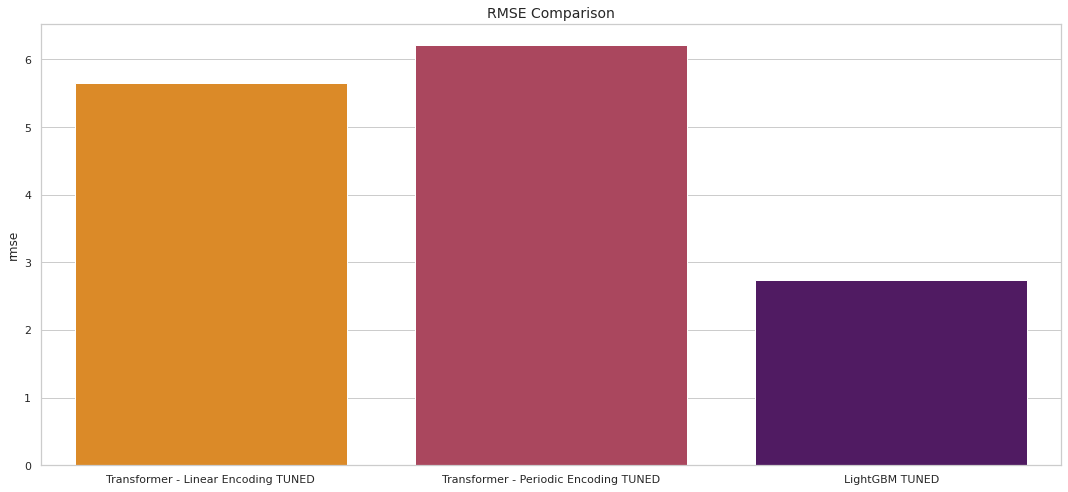

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


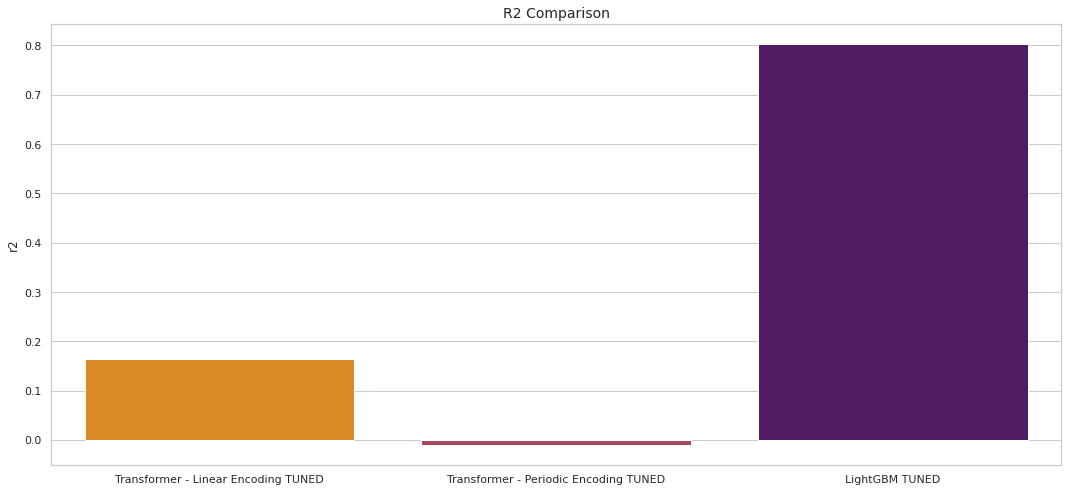

In [ ]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
